In [3]:
!date

Mon Apr  5 11:29:49 EDT 2021


# Identify coast-crossing vapor lakes (CCVL)

In [5]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
#import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Find the east coast of equatorial Afr-abia
### x-derivative of land mask, in 30-70, 20S-20N 

In [19]:
land_msk = xr.open_dataset('landmask_MERRA2.nc')
lm = land_msk.sel(lon=slice(30,100),lat=slice(-20,20))
lon = lm.lon.squeeze()
lat = lm.lat.squeeze()
lm

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 113, time: 1)
Coordinates:
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.5 19.0 19.5 20.0
  * time     (time) datetime64[ns] 1989-01-01T12:00:00
Data variables:
    lsm      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.4 (http://code.zmaw.de/p...
    Conventions:  CF-1.6
    history:      Thu Nov 29 16:47:34 2018: cdo remapbil,mygrid landmask.nc l...
    CDO:          Climate Data Operators version 1.6.4 (http://code.zmaw.de/p...

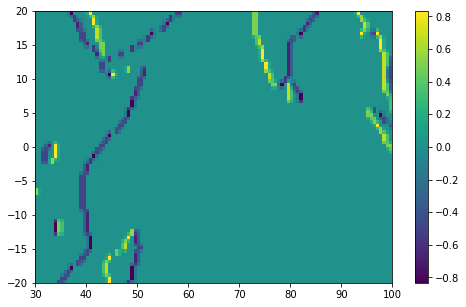

In [20]:
fig = plt.figure(figsize=(8,5))
plt.pcolor(lm.lon,lm.lat,lm.lsm.squeeze().diff("lon"))
plt.colorbar()

In [21]:
lm["eastcoast"] = xr.full_like(lm.lsm.diff("lon"), fill_value=0)

In [22]:
# Assign values in a spatial box
# https://xarray.pydata.org/en/stable/indexing.html#assigning-values-with-indexing

lc = lm.coords["lon"]
la = lm.coords["lat"]

locxxx = dict(lon=lc[(lc < 70) & (lc > 36)], lat=la[(la < 9999)])

lm["eastcoast"].loc[locxxx] = lm["lsm"].loc[locxxx].squeeze()

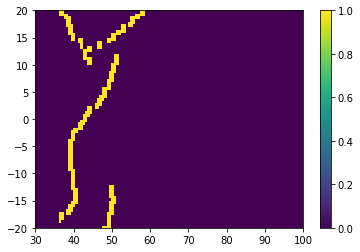

In [70]:
maskweight= (lm.eastcoast.squeeze().diff("lon") <0).astype(float)
plt.pcolor(lm.lon,lm.lat,maskweight)
plt.colorbar()

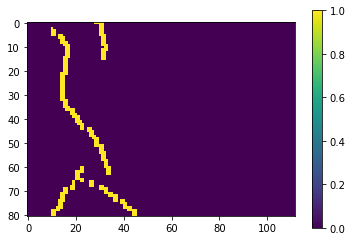

In [68]:
plt.imshow(maskweight); plt.colorbar()

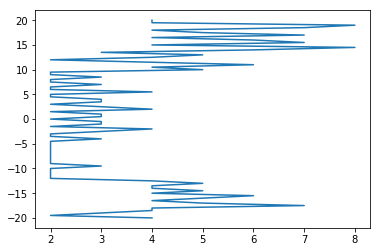

In [72]:
# Do the -diff() values add up to 1 like wieghts? Not as cast now 
plt.plot(maskweight.sum(dim="lon").squeeze(), la)

#print(maskweight.sum(dim="lon"))

# Grab data and extract coastal time-lat series 

In [3]:
MERRA2_dir = '/data2/willytsai/MERRA2/inst_2d_hourly/'
# os.chdir(MERRA2_dir)

In [111]:
files = glob(MERRA2_dir+'*201[4,5]01*')
files

['/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140101.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140102.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140103.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140104.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140105.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140106.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140107.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140108.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140109.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140110.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.inst1_2d_asm_Nx.20140111.SUB.nc',
 '/data2/willytsai/MERRA2/inst_2d_hourly/MERRA2_400.in

In [112]:
files = glob(MERRA2_dir+'*201[4,5,6,7,8]*') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one

In [113]:
cwv_data

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 576, time: 43824)
Coordinates:
  * lat      (lat) float64 -30.0 -29.5 -29.0 -28.5 -28.0 ... 28.5 29.0 29.5 30.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Data variables:
    TQV      (time, lat, lon) float32 dask.array<chunksize=(24, 121, 576), meta=np.ndarray>
Attributes:
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Fri Jan 13 16...
    Comment:                           GMAO filename: d5124_m2_jan10.inst1_2d...
    Filename:                          MERRA2_400.inst1_2d_asm_Nx.20170101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2I1NXASM
    GranuleID:                         MERRA2_400.inst1_2d_asm_Nx.20170101.nc4
    ProductionDateTime:                Original file generated: Fri Jan 13 16...
    LongName:                          MERRA2 inst1_2d_asm_Nx: 2d,3-Hourly,In...
    Title:                             MERRA2 inst1_2d_asm_Nx: 2d,3-Hourly,In...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/3Z173KIE2TPD
    RangeBeginningDate:                2017-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2017-01-01
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.1 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [114]:
lon = cwv_data.lon
lat = cwv_data.lat

TQV = cwv_data.TQV

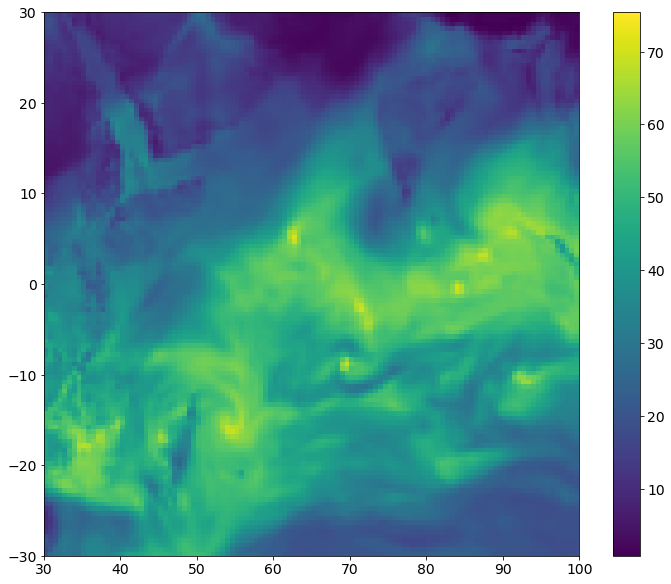

In [129]:
fig = plt.figure(figsize=(12,10))
plt.pcolor(lon,lat,TQV[0,:,:])
plt.xlim(30,100)
plt.colorbar()

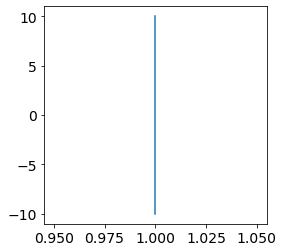

In [94]:
# Do the -diff() values add up to 1 like wieghts? Answer: yes 
maskweight = -lsm.sel(lon=slice(38,52),lat=slice(-10,10)).diff("lon")

fig = plt.figure(figsize=(4,4))
plt.plot(maskweight.sum(dim="lon"), 
          lat.sel(lat=slice(-10,10)))



In [115]:
# lsm.sel(lon=slice(38,52),lat=slice(-10,10)).diff("lon") )

TQV_WEIO = (TQV.sel( lon=slice(38,52),lat=slice(-10,10) ) * maskweight).sum(dim="lon")

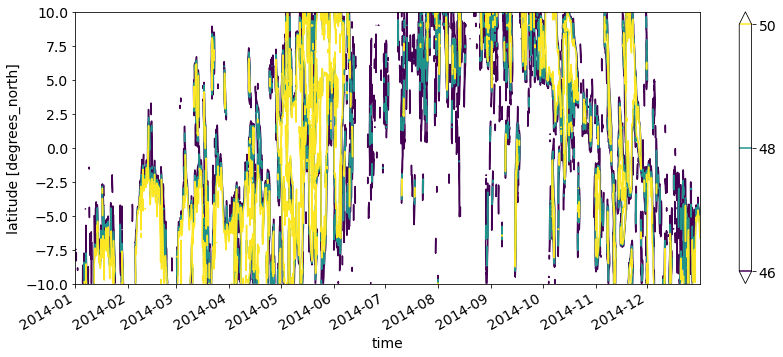

In [100]:
#fig = plt.figure(figsize=(20,5))
#TQV_WEIO.transpose().plot.contour(vmin=46,vmax=50,levels=3, add_colorbar=True)
#plt.title('Latitude-time contours along Africa east coast')

# Open the data file of all time slices 

In [6]:
!ls -atlh /data2/brian/WEIO_30-100_20S-20N_2014-8.nc

-rw-rw-r-- 1 bmapes bmapes 755M Mar 10 18:55 /data2/brian/WEIO_30-100_20S-20N_2014-8.nc


In [7]:
TQV_WEIO = xr.open_dataset('/data2/brian/WEIO_30-100_20S-20N_2014-8.nc')
TQV_WEIO

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 113, time: 43824)
Coordinates:
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.5 19.0 19.5 20.0
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Data variables:
    TQV      (time, lat, lon) float32 ...

# Start at the end and move backward one step